# Exercise 7

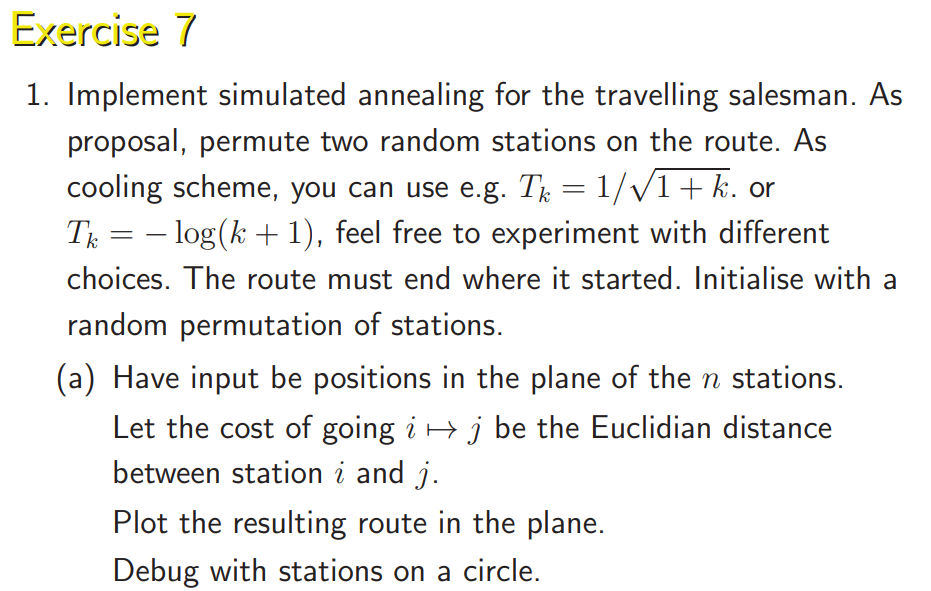

This is a Travelling Salesman Problem, where we utilize the Simulated Annealing algorithm. Herein, the goal is to find the shortest possible rote when visiting $n$ stations and returning to the starting point. We follow the follwong plan to execute the TSP algorithm:

- Stations are represented by their coordinates
- The distances are calculated using Euclidean metric
- The algorithm is initialized with a random route, which is iteratively refined
- At each iteration, randomly swap two stations and either accept or reject adding it to the route. This is based on the cooling scheme $T_k$

We set the number of stations to be $n=10$ and set them in a perfect circle:

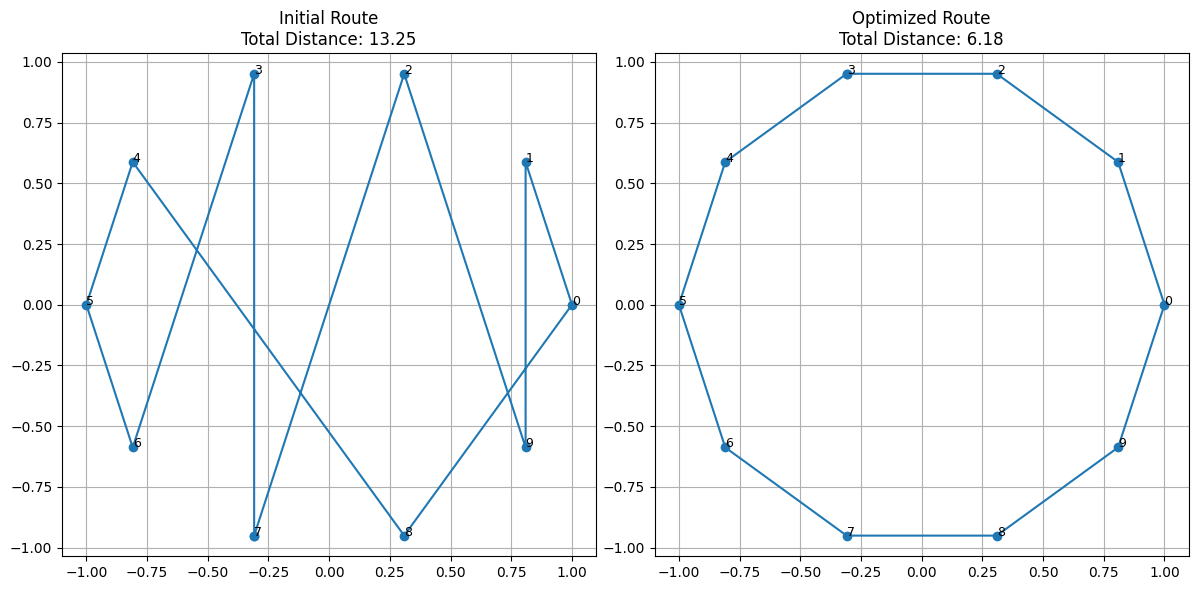

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random
np.random.seed(1234)

n = 10
iterations = 10000
cooling = lambda k: 1 / np.sqrt(1 + k)  
circle_debug = True

if circle_debug:
    angles = np.linspace(0, 2*np.pi, n, endpoint=False)
    positions = np.stack((np.cos(angles), np.sin(angles)), axis=1)
else:
    positions = np.random.rand(n, 2)  

def total_distance(route, positions):
    dist = 0
    for i in range(len(route)):
        a, b = positions[route[i]], positions[route[(i + 1) % len(route)]]
        dist += np.linalg.norm(a - b)
    return dist

initial_route = list(np.random.permutation(n))
initial_cost = total_distance(initial_route, positions)

current_route = list(np.random.permutation(n))
current_cost = total_distance(current_route, positions)
best_route = current_route.copy()
best_cost = current_cost

for k in range(1, iterations + 1):
    i, j = random.sample(range(n), 2)
    new_route = current_route.copy()
    new_route[i], new_route[j] = new_route[j], new_route[i]
    new_cost = total_distance(new_route, positions)
    delta = new_cost - current_cost

    if delta < 0 or np.random.rand() < np.exp(-delta / cooling(k)):
        current_route = new_route
        current_cost = new_cost
        if current_cost < best_cost:
            best_route = current_route
            best_cost = current_cost

def plot_comparison(initial_route, best_route, positions):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    for ax, route, title in zip(axes, [initial_route, best_route], ["Initial Route", "Optimized Route"]):
        pos = positions[route + [route[0]]]
        ax.plot(pos[:, 0], pos[:, 1], 'o-', label="Path")
        for i, p in enumerate(pos[:-1]):
            ax.text(p[0], p[1], str(route[i]), fontsize=9)
        ax.set_title(f"{title}\nTotal Distance: {total_distance(route, positions):.2f}")
        ax.axis("equal")
        ax.grid(True)
    plt.tight_layout()
    plt.show()

plot_comparison(initial_route, best_route, positions)


As can be observed, the initial route has a total cost of 13.25, while the optimized route has a total distance of 6.18.

This proves that the algorithm is adept at find the optimal route.

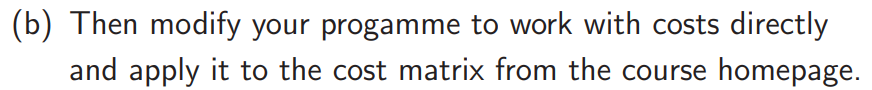

Now, we add a cost matrix to a mix. Specifically, the costs are calculated following a Uniform distribution, $X\sim \text{Uniform}(10,30)$. Stations' locations in the plot is no longer in a perfect circle, but now represent the cost matrix:

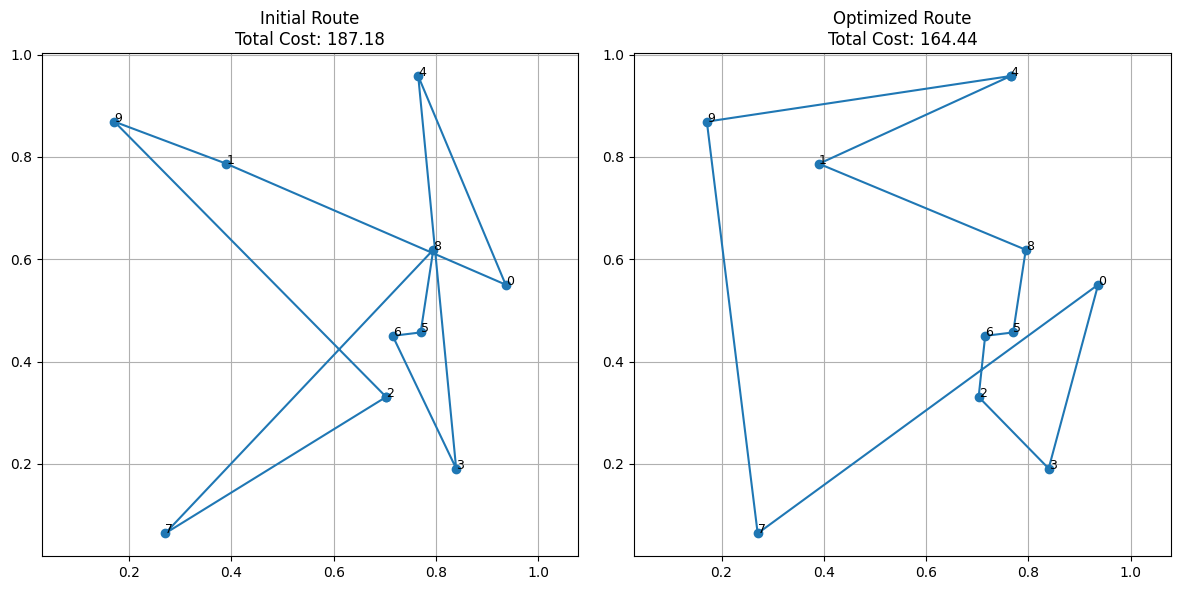

In [3]:
raw_matrix = np.random.uniform(10, 30, size=(n, n))
np.fill_diagonal(raw_matrix, 0)
cost_matrix = (raw_matrix + raw_matrix.T) / 2

positions = np.random.rand(n, 2)

def total_distance(route, cost_matrix):
    return sum(cost_matrix[route[i], route[(i + 1) % n]] for i in range(n))

initial_route = list(np.random.permutation(n))
initial_cost = total_distance(initial_route, cost_matrix)

current_route = initial_route.copy()
current_cost = initial_cost
best_route = current_route.copy()
best_cost = current_cost

for k in range(1, iterations + 1):
    i, j = random.sample(range(n), 2)
    new_route = current_route.copy()
    new_route[i], new_route[j] = new_route[j], new_route[i]
    new_cost = total_distance(new_route, cost_matrix)
    delta = new_cost - current_cost

    if delta < 0 or np.random.rand() < np.exp(-delta / cooling(k)):
        current_route = new_route
        current_cost = new_cost
        if current_cost < best_cost:
            best_route = current_route
            best_cost = current_cost

def plot_comparison(initial_route, best_route, cost_matrix, positions):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    for ax, route, title in zip(axes, [initial_route, best_route], ["Initial Route", "Optimized Route"]):
        pos = positions[route + [route[0]]]
        ax.plot(pos[:, 0], pos[:, 1], 'o-')
        for i, (xi, yi) in enumerate(pos[:-1]):
            ax.text(xi, yi, str(route[i]), fontsize=9)
        ax.set_title(f"{title}\nTotal Cost: {total_distance(route, cost_matrix):.2f}")
        ax.axis("equal")
        ax.grid(True)
    plt.tight_layout()
    plt.show()

plot_comparison(initial_route, best_route, cost_matrix, positions)


# Exercise 8

As can be observed, the optimized route is cheaper than the intial route, as to be expected. Thus, the algorithm can also handle specific cost value between the statios $n$.

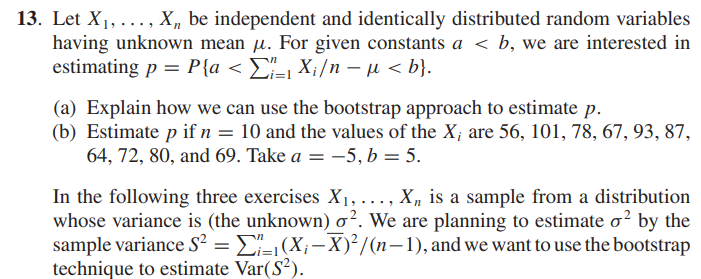

$\textbf{(a)}$ We are interested in estimating 
$$
p=P{a<\sum _{i=1} ^n X_i /n - \mu < b}
$$
Here, $\mu$ is of unknown quantity and thus, we cannot just evaluate the probabilty $p$. Therefore, we will use the bootstrap method to estimate it.

The idea is to use $\bar{X}$ which we plug in place of $\mu$. Using this newly acquired distribution, we generate many bootstrap samples, wherein we can for each batch calculate the means $\bar{X}_i ^*$ and the deviations $\bar{X}_i^*-\bar{X}$.

Finally, we can calculate the proportion of times the deviations fall in the interval [$a,b$], $\hat{p}$, which is an estimator for $p$:
$$
\hat{p} = \frac{1}{r} \sum _{i=1} ^r \{a< \bar{X}_i ^*-\bar{X}< b\} 
$$

$\textbf{(b)}$ With our values, we can use the bootstrap method with 10000 samples.

In [7]:
data = np.array([56, 101, 78, 67, 93, 87, 64, 72, 80, 69])
n = 10
a, b = -5, 5
r = 10000

original_mean = np.mean(data)
bootstrap_means = []

for _ in range(r):
    sample = np.random.choice(data, size=n, replace=True)
    bootstrap_means.append(np.mean(sample))

bootstrap_means = np.array(bootstrap_means)
shifts = bootstrap_means - original_mean

p_estimate = np.mean((shifts > a) & (shifts < b))
print(f"Estimated p = {p_estimate:.4f}")

Estimated p = 0.7647


Based on the bootstrap, there is a 76.5% probability that the sample mean falls within $\pm5$ of the true mean $\mu$.

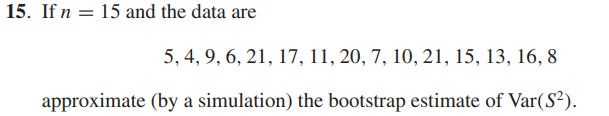

We approximate the variance of the sample variance $S^2$ using the bootstrap method.

In order to do this, we compute many bootstrap resamples from the original data. For each sample, we compute the sample variance $S^2=\frac{1}{n-1} \sum (X_i - \bar{X})^2$.

From this, we can estimate the variance of variances:
$$
\hat{\text{V}}(S^2) = \frac{1}{n-1} \sum _{i=1} ^r (S^2 _i - \bar{S}^2 _i)^2
$$

In [8]:
data = np.array([5, 4, 9, 6, 21, 17, 11, 20, 7, 10, 21, 15, 13, 16, 8])
n = len(data)
r = 10000

np.random.seed(42)

bootstrap_vars = []

for _ in range(r):
    sample = np.random.choice(data, size=n, replace=True)
    sample_var = np.var(sample, ddof=1)
    bootstrap_vars.append(sample_var)

bootstrap_vars = np.array(bootstrap_vars)
var_of_sample_var = np.var(bootstrap_vars, ddof=1)

print(f"Bootstrap estimate of Var(S²): {var_of_sample_var:.4f}")

Bootstrap estimate of Var(S²): 59.1453


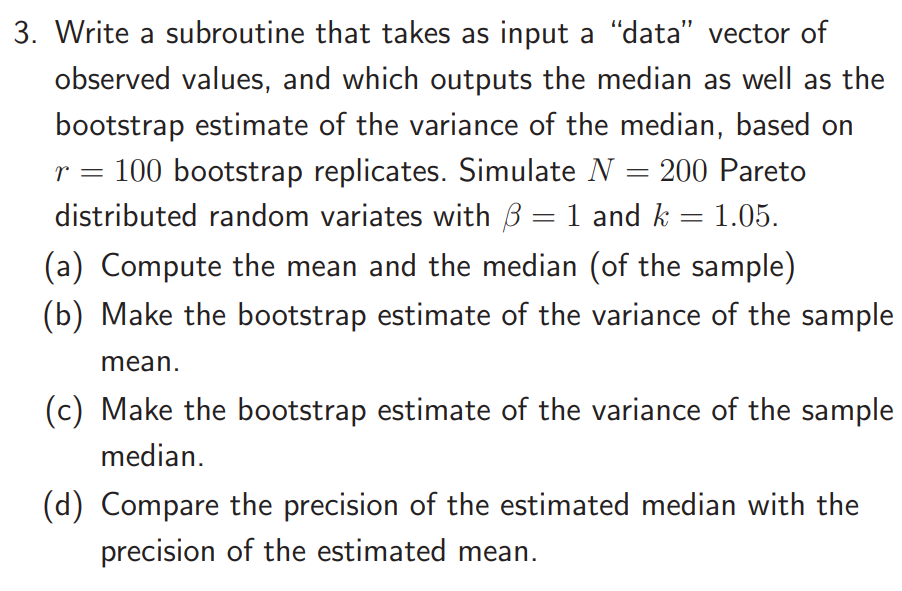

$\textbf{(a)}$ In order to compute the mean and the median of the sample, we 

In [9]:
N = 200
beta = 1
k = 1.05

data = (np.random.pareto(k, size=N) + 1) * beta

mean_val = np.mean(data)
median_val = np.median(data)

print(f"Sample Mean: {mean_val:.4f}")
print(f"Sample Median: {median_val:.4f}")

Sample Mean: 4.2593
Sample Median: 1.9737
